# PSD Peak Detection through Cross Validation and K-Means Clustering
Does not use bootstrapping

This notebook contains the code to extract peak parameters from PSDs of electrodes of a single subject. It is organized in the following manner :

* Import necessary python libraries and load data
* Define helper functions for finding peaks in PSDs
* Define helper functions for k-means clustering
* Define helper functions for bootstrapping
* Iterate through electrodes and perform cross-validation
* Plot Results

Each of the helper functions also has a docstring with a short description and summary of input arguments and output results.

##Import Libraries 
Import necessary libraries.

In [25]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [26]:
from __future__ import division
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import scipy.io
import scipy.signal
from sklearn.metrics import r2_score
from sklearn import cross_validation
from sklearn import cluster
import seaborn as sns
import pandas as pd
import cPickle as pickle
import sys
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

###Process_Elec_Data
Given trials x time for a particular electrode, calculates the mean PSD, mean flatspec, and frequency vector

In [27]:
def process_elec_data(elec_data, srate):
    """
    Returns the f, mean, (mean - 1/f^2) of trials in elec_data

    Args:
      elec_data: Matrix of electrode data (trials x time)

    Returns:
      f: vector of frequencies (spacing decided with signal.welch)
      psd_mean: average psd of all trials in elec_data matrix
      flatspec: psd_mean - (1/f^2)

    """
    # Resample
    newsrate = 256 # new sampling rate
    if srate!=newsrate:
        elec_data = sp.signal.resample(elec_data, int(np.floor(len(elec_data)*(newsrate/srate))))
  
    # Calculate trial and mean PSDs for testing range of trials
    f,psd_trial = sp.signal.welch(elec_data, fs=newsrate, window='hanning', nperseg=newsrate, noverlap=newsrate/2.0, nfft=None, detrend='linear', return_onesided=True, scaling='density')
    psd_mean = psd_trial.mean(0)
    
    #Cut PSD according to frequency range of interest (1-50Hz)
    f = f[1:50]
    psd_mean = np.log10(psd_mean[1:50])
    
    #Calculate Flatspec (PSDMean - 1/f^2)
    slope_params = np.polyfit(f, psd_mean, 2)
    slopefit = np.polyval(slope_params, f)
    flatspec = psd_mean - slopefit
    
    return (f,psd_mean, flatspec)

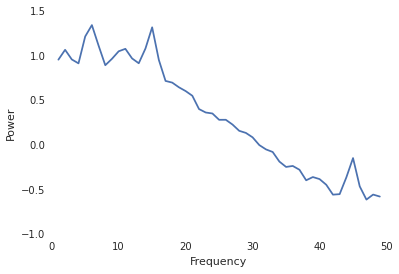

In [28]:
'''Import and check data'''

datafolder = '/../' # path to EEG_1elec_epoched_data.mat
fname = 'EEG_1elec_epoched_data.mat';
os.chdir(datafolder);
data = sp.io.loadmat(fname);
data = squeeze(data['elec_dat']);
fx,pow_spec,flatspec = process_elec_data(data,256);
plot(fx,pow_spec)
ylabel('Power')
xlabel('Frequency')

##Helper Functions for to Find Peaks and Fit Gaussians
The following functions are used to identify peaks (```find_peaks```), create a combination of Gaussians given necessary parameters (```norm```), and find the best fit of Gaussians to a given function.

###Norm
Norm takes in a vector of frequencies (essentially the x-axis) and a vector of parameters (arg) that characterizes the Gaussians. It uses these parameters to create a combination of Gaussians and returns it as fitdat.
For example, if the following peaks were found:

| Peaks | Amplitude | Std Dev |
|------|------|----|
|   7.0  | 0.05| 1.35|
|   22.0  | 0.13| 0.66|

then the arg vector would be 
```python
[7.0 22.0 0.05 0.13 1.35 0.66 2]
```
where the last 2 stands for the total number of peaks found

In [29]:
def norm(x, *args):
    """
    Calculates a combination of Gaussians given parameters
    
    Args:
      x: vector of frequencies
      *args: vector of Gaussian parameters (Gaussian center, Gaussian standard deviation, Gaussian height, # of Gaussians)

    Returns:
      fitdat: combination of Gaussians

    """
    number_of_gaussians = int(args[-1]) # number of gaussians from peak detection
    fitdat = np.array(0)
    for peaki in range(number_of_gaussians):
        fitdat = fitdat + args[peaki+(2*number_of_gaussians)]*sp.stats.norm.pdf(x, loc=args[peaki], scale=args[peaki+number_of_gaussians]) # add a bunch of gaussians together
    return fitdat

###Find_Peaks
Uses Python's built in ```sp.signal.find_peaks_cwt ``` in order to find peaks using the given sliding window on the given flatspec (PSD - $\frac{1}{f^2}$). The first window starts at 0Hz and looks for a peak between 0Hz and ```sliding_window```Hz. The next window starts at 2Hz and goes till ```sliding_window```+2Hz. This process continues till the entire freequency range has been covered.

A sliding window is used to ensure that low amplitude peaks are not ignored. The 2Hz overlap ensures that peaks at edges of the sliding windows aren't missed [MAKE CLEAR].

In [30]:
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array
 
    
def peakdect(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arraysX
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True
 
    return array(maxtab), array(mintab)

In [31]:
def find_peaks (flatspec, sliding_window, f):
    """
    Detects peaks in flatspec in in chunks of width sliding_window. A window overlaps previous window by 2Hz
    
    Args:
      flatspec: psd_mean - (1/f^2)
      f: frequency of vectors
      sliding_window: width of sliding window for detecting peaks

    Returns:
      peaks: indices of peak locations in flatspec
    """
    maxpks, minpks = peakdect(flatspec, sliding_window, f) # find peaks in sliding window range
    try:	
    	peakind = [np.uint32(i) for i in (array(maxpks)[:,0]) if i <= 30] #ignore peaks beyond 30Hz
    except Exception:
	peakind = [-1]
    try:
    	valleyind = [np.uint32(i) for i in (array(minpks)[:,0]) if i <= 30] #ignore peaks beyond 30Hz
    except Exception:
	valleyind = [-1]
    return peakind, valleyind

###Transform_Data
Takes list of all parameters from CV and converts into form for Kmeans clustering and separates peaks from sliding windows for plotting. Currently allowing for a maximum of three sliding windows.

In [32]:
def transform_data (params):
    """
    Converts list of lists to matrix in form (n_components x n_features)

    Args:
      params: parameters from CV folds

    Returns:
      X: matrix of parameters

    """
    #separate peaks for each sliding window width
    peaks_np = np.array(params)
    #separate peaks for each sliding window width
    peaks1 = [elem for sublist in map(list, peaks_np[:,0,:]) for elem in sublist if elem >=0] #only include peaks less than 30Hz
    peaks2 = [elem for sublist in map(list, peaks_np[:,1,:]) for elem in sublist if elem >=0] #only include peaks less than 30Hz
    peaks3 = [elem for sublist in map(list, peaks_np[:,2,:]) for elem in sublist if elem >=0] #only include peaks less than 30Hz]

    #combine all peaks for input into Kmeans clustering algorithm
    peaks_comp = np.array(peaks1+peaks2+peaks3)
    peaks_comp = [elem for elem in peaks_comp if (elem<30 and elem >= 0)] #only include peaks less than 30Hz
    X = np.reshape(peaks_comp, (1,len(peaks_comp)))
    X=X.transpose()
    return X, peaks1, peaks2, peaks3

###KMeans
Uses ```scikit.learn.cluster.KMeans``` to find ```cluster_size``` clusters among all peaks from all CV folds and all sliding window widths (in ```X```). 
Returns cluster centers and sum of squares

In [33]:
def kmeans(X, cluster_size):
    """
    Returns the cluster centroids and SoS from centroids

    Args:
      X: Data (n_componentsxn_features) to cluster

    Returns:
      clusters: cluster centroids
      inertia: SoS

    """
    km = cluster.KMeans(n_clusters=cluster_size)
    km.fit(X)
    clusters = km.cluster_centers_
    return clusters, km.inertia_

###Find_Clusters
Uses the list of sum of squares for each cluster size to find "knee" in fit. Also takes into consideration the change in SoS after the knee in order to account for missed cluster centers. [REWRITE]

In [34]:
def find_cluster(X):
    """
    Finds ideal number of clusters
    
    Args:
        peaks: list of all peaks
    Returns:
        ideal number of clusters
    """
    SoS_list = []
    peaks = X[:,0:1]
    med = np.median(peaks)
    zeroSoS = sum(((x-med)*(x-med) for x in peaks))
    SoS_list.append(zeroSoS)
    for cluster_size in range (1, 6):
        p,SoS_tmp = kmeans(X, cluster_size)
        SoS_list.append((SoS_tmp))
        
    dx = np.array(SoS_list[:-1]) - np.array(SoS_list[1:]) #calculate difference in SoS
    SoS_knee = np.argmax(dx) #pick max change
    return SoS_knee+2, SoS_list

### Cross Validation Function
Calls above functions and performs multiple fits without bootstrapping on peak locations. Saves the parameters in the folder fname in your home directory.

In [61]:
def CV(elec_data, srate,fname):
    """
    Uses the above functions to cross-validate an electrode of data and saves all of the generated parameters
    
    Args:
        DATASET: list of all channels of interest i.e. range(64)
        data: trials x time for one electrode
        srate: sampling rate
        fname: path to directory to save parameters.   i.e. '/../Voytek_PSD_fitting_algorithm_output'
    """
    
    freq_vector, psd_mean, flatspec = process_elec_data(elec_data, srate)
    os.chdir('/../')
    folder = fname
    if not os.path.exists(folder):
        os.makedirs(folder)
    os.chdir(folder)
    np.save('flatspec.npy', flatspec)
    np.save('psd_mean.npy', psd_mean)
    np.save('freq_vector.npy', freq_vector)

    extcv = range(0,100)
    deltas = [0.03, 0.05, 0.07] 
    extcv_amps = []
    extcv_rsq = []
    extcv_std = []
    extcv_pks = []
    extcv_fit = []   
    extcv_trial = []
    extcv_valid = []
    extcv_cluster_peaks = []
    extcv_params = []
    extcv_rscore=[]
    extcv_delta_pks=[]

    for i in extcv:

        """Perform Cross Validation"""
        #Set aside validation set
        elec_data_train, elec_data_valid = cross_validation.train_test_split(elec_data, test_size=0.2, random_state=np.uint(np.random.rand(1)*100)[0]) #split into test and validation set #split into test and validation set

        #Split train set into 100 train and test sets
        ss = cross_validation.ShuffleSplit(int(np.size(elec_data_train,0)*0.8), n_iter=100, test_size=0.2, random_state=0)

        #Use each window width on each of the 100 folds for fitting Gaussians
        peaks_cv=[]
        valleys_cv=[]
        for train_index, test_index in ss:
            #split into train and test set
            trials_train = elec_data_train[train_index,:]
            trials_test = elec_data_train[test_index,:]
            freq_vector, _, flatspec_train = process_elec_data(trials_train, srate)  #calculate train flatspec
            _, _, flatspec_test = process_elec_data(trials_test, srate)  #calculate test flatspec
            peaks_cv_temp = np.zeros((3,12))
            valleys_cv_temp = np.zeros((3,12))
            #find Gaussian fit parameters for each window width
            for d in range(0,len(deltas)):
                delta = deltas[d]
                peaks_temp, valleys_temp = find_peaks(flatspec_train, delta, freq_vector)
                peaks_temp_vect = np.zeros(12)
                valleys_temp_vect = np.zeros(12)
                peaks_temp_vect[0:len(peaks_temp)] = peaks_temp
                valleys_temp_vect[0:len(valleys_temp)] = valleys_temp
                peaks_cv_temp[d] = peaks_temp_vect
                valleys_cv_temp[d] = valleys_temp_vect
            peaks_cv.append((peaks_cv_temp))
            valleys_cv.append((valleys_cv_temp))

        extcv_delta_pks.append((peaks_cv))
        #Reshape Gaussian parameters to k-means clustering input format
        X_peaks, peaks1, peaks2, peaks3 = transform_data(peaks_cv)
        peaks = X_peaks[:,0:1]

        X_valleys, valleys1, valleys2, valleys3 = transform_data(valleys_cv)
        valleys = X_valleys[:,0:1]

        #Find ideal number of clusters, return all SoS for plotting
        cluster_num_peaks, cluster_SoS_peaks = find_cluster(X_peaks) 
        cluster_num_valleys, cluster_SoS_valleys = find_cluster(X_valleys) 

        #process valid and train sets
        f, mean_train, flatspec_train = process_elec_data(elec_data_train, srate)
        _, mean_valid, flatspec_valid = process_elec_data(elec_data_valid, srate)
        extcv_trial.append((flatspec_train))
        extcv_valid.append((flatspec_valid))

        #use ideal number of clusters to generate best fit
        cluster_peaks,_ = kmeans(X_peaks,cluster_num_peaks)
        cluster_valleys,_ = kmeans(X_valleys,cluster_num_valleys)
        peak = [elem for sublist in map(list, np.array(cluster_peaks)) for elem in sublist]
        valley = [elem for sublist in map(list, np.array(cluster_valleys)) for elem in sublist]
        cluster_all = peak+valley
        peakind = np.uint32([p for p in cluster_all if p>=1 and p<=30])
        p = np.linspace(1, len(peakind), len(peakind))
        params = list(freq_vector[peakind]) + list(p.T) + list(flatspec_train[peakind]) + [len(peakind)] # initial guess for parameters based on peak detection
        try:
            oscillatory_fit_params,_ = sp.optimize.curve_fit(norm, f, flatspec_train, p0=params) # fitting parameters
        except RuntimeError:
            print('FAILED FIT')
            continue

        cluster_fit = norm(f, *oscillatory_fit_params)
        rsq = r2_score(flatspec_valid, cluster_fit)
        cluster_num = oscillatory_fit_params[-1]
        test_peaks = oscillatory_fit_params[0:cluster_num]
        extcv_amps.append((oscillatory_fit_params[2*cluster_num:3*cluster_num]))
        extcv_std.append((oscillatory_fit_params[cluster_num:2*cluster_num]))
        extcv_pks.append((oscillatory_fit_params[0:cluster_num]))
        extcv_cluster_peaks.append((cluster_peaks))
        extcv_fit.append((cluster_fit))
        extcv_params.append((oscillatory_fit_params))
        extcv_rscore.append((rsq))

    print('Saving...')

    np.save('flatspec.npy', flatspec)
    np.save('psd_mean.npy', psd_mean)
    np.save('freq_vector.npy', freq_vector)
    np.save('cluster_num_peaks.npy', cluster_num_peaks)
    np.save('cluster_num_valleys.npy', cluster_num_valleys)
    np.save('peaks1.npy', peaks1)
    np.save('peaks2.npy', peaks2)
    np.save('peaks3.npy', peaks3)
    np.save('extcv_rscore.npy', extcv_rscore)
    np.save('valleys1.npy', valleys1)
    np.save('valleys2.npy', valleys2)
    np.save('valleys3.npy', valleys3)
    np.save('cluster_peaks.npy', cluster_peaks)
    np.save('cluster_valleys.npy', cluster_valleys)
    np.save('extcv_std.npy', extcv_std)
    np.save('extcv_pks.npy', extcv_pks)
    np.save('extcv_params.npy', extcv_params)
    np.save('extcv_amp.npy', extcv_amps)
    np.save('extcv_fit.npy', extcv_fit)
    np.save('extcv_trial.npy', extcv_trial)
    np.save('extcv_valid.npy', extcv_valid)
    np.save('extcv_cluster_peaks.npy', extcv_cluster_peaks)
    np.save('cluster_SoS_peaks.npy', cluster_SoS_peaks)
    np.save('cluster_SoS_valleys.npy', cluster_SoS_valleys)
    np.save('extcv_delta_pks.npy', extcv_delta_pks)
    os.chdir('..') 



### Code to create CSV files
Code to build csv files from saved out variables. I was running the code on the cluster and creating the CSVs locally, so it might be redundant run the code 

###Bootstrap code to calculate final values and confidence intervals

In [50]:
def bootstrap(data):
    bootstrap_dist = np.zeros(1000)
    for i in range(0,1000):
        total_points = len(data)
        data_sample = np.random.choice(np.array(data), size=int(0.8*total_points))
        bootstrap_dist[i] = median(data_sample)
    return [median(bootstrap_dist), percentile(bootstrap_dist, 2.5), percentile(bootstrap_dist, 97.5)]

In [51]:
def plot_final_fit(freq_vector, psd_mean, flatspec, extcv_rscore, cp, extcv_fit, valid_peak_range, sorted_params, mtx_main, ax):
    """ Subplot 1: Plots Final Fit, Mean PSD, Final Fit Peaks and Bandwidths"""
        
    plot(freq_vector, psd_mean, color=cp[0])
    sns.tsplot(extcv_fit+(psd_mean - flatspec), freq_vector, color=cp[2], condition='Final Fit')
    legend(['Original PSD', 'Final Fit'], loc='best', fontsize=16)
        
    med_peaks_lst = np.zeros(len(valid_peak_range))
    #Sorted params matrix, Find medians
    for j in range(len(valid_peak_range)):
        med_peak = median(sorted_params[j],1)[0]
        med_std = median(sorted_params[j],1)[1]
        med_peaks_lst[j] = med_peak
        if med_std <=10:
            cf_params = bootstrap(sorted_params[j][0])
            bw_params = bootstrap(2.355*sorted_params[j][1])
            r2_params = bootstrap(extcv_rscore)
           
            ax.annotate('CF: ' + str(round(cf_params[0],2)) + 'Hz', xy=(cf_params[0]+0.1, (mean(extcv_fit,0)+(psd_mean - flatspec))[cf_params[0]]-0.1))
            ax.annotate('BW: ' + str(round(bw_params[0],2)) + 'Hz', xy=(cf_params[0]+0.1, (mean(extcv_fit,0)+(psd_mean - flatspec))[cf_params[0]]-0.2))
            plot(cf_params[0], (extcv_fit.mean(0)+(psd_mean - flatspec))[cf_params[0]], 'ko')
            
            y1,y2 = ax.get_ylim()
            fill([cf_params[0]-bw_params[0]/2.0,cf_params[0]+bw_params[0]/2.0,cf_params[0]+bw_params[0]/2.0,cf_params[0]-bw_params[0]/2.0], 
                 [y1, y1, y2, y2], alpha=0.2, color='0.5')
            
            mtx_main.append([cf_params[0], cf_params[1], cf_params[2], bw_params[0], bw_params[1], bw_params[2], r2_params[0], r2_params[1], r2_params[2], 100-len(extcv_fit)])
    xlabel('Frequency (Hz)'); ylabel('Power'); title('Gaussian Fits, Peaks and Bandwidths', fontsize=16)
    return mtx_main

In [52]:
def plot_cf_hist(extcv_pks_raster, cluster_pks, cp, ax):
    """ Subplot 2: Plots Final Fit Peaks Histogram"""
    plt.hist(extcv_pks_raster, range=(0,35), color=cp[2])
    ax.set_xlim([0, 40])
    xlabel('Frequency (Hz)'); ylabel('Count'); title('Distribution of Peaks from Fits', fontsize=16)

In [53]:
def plot_cluster_hist(extcv_pks_raster, cluster_pks, cp, ax):
    """ Subplot 5: Plots Clustered Peaks Histogram"""
    plt.hist(cluster_pks, range=(0,35), color=cp[3])
    ax.set_xlim([0, 40])
    xlabel('Frequency (Hz)'); ylabel('Count'); title('Distribution of Peaks from Clustering', fontsize=16)

In [54]:
def plot_clustercf_hist(extcv_pks_raster, cluster_pks, cp, ax):
    """ Subplot 2: Plots Clustered and Fit Peaks Histogram"""
    plt.hist(extcv_pks_raster, range=(0,35), color=cp[2], alpha = 0.5)
    plt.hist(cluster_pks, range=(0,35), color=cp[4], alpha = 0.5)
    ax.set_xlim([0, 40]); legend(['Fit Peaks', 'Cluster Peaks'], loc='best', fontsize=16)
    xlabel('Frequency (Hz)'); ylabel('Count'); title('Distribution of Peaks', fontsize=16)

In [55]:
def plot_fold_fitpks(extcv_fit, extcv_trial, psd_mean, flatspec, freq_vector, ax, cp, extcv_pks):
    """ Subplot 3: Fit Peaks from each Fold"""
    for i in range(size(extcv_fit,0)-1):
            plot(freq_vector, extcv_trial[i]+(psd_mean - flatspec), color=cp[5])
            pks = [elem for elem in extcv_pks[i] if elem>=0 and elem<=48]
            plot(pks, (extcv_trial[i]+psd_mean - flatspec)[pks], 'ko')
            if i==0:
                legend(['Trial PSD', 'Fit Peaks'], loc='best', fontsize=16)
    ax.set_xlim([0, 50])
    xlabel('Frequency (Hz)'); ylabel('Power'); title('Fit Peaks from All Folds', fontsize=16)

In [56]:
def plot_cluster_pks(freq_vector, psd_mean, valid_peak_range, cp, sorted_params, ax):
    """ Subplot 4: Binned Clustered Peaks"""
    plot(freq_vector, psd_mean, color=cp[0])
    for j in range(len(valid_peak_range)):
        cf_params = bootstrap(sorted_params[j][0])
        ax.annotate('CF: ' + str(round(cf_params[0],2)) + 'Hz', xy=(cf_params[0]+0.1, (psd_mean)[cf_params[0]]-0.1))
        plot(cf_params[0], (psd_mean)[cf_params[0]], 'ko')
    ax.set_xlim([0, 50])
    xlabel('Frequency (Hz)'); ylabel('Power'); title('Cluster Peaks', fontsize=16)   
    legend(['Original PSD'], loc='best', fontsize=16)

In [57]:
def plot_fold_clusterpks(ax,freq_vector, extcv_fit, extcv_trial, psd_mean, flatspec, cp, extcv_cluster_pks):
    """ Subplot 6: Clustered Peaks from each Fold"""
    for i in range(size(extcv_fit,0)-1):
        plot(freq_vector, extcv_trial[i]+(psd_mean - flatspec), color=cp[5])
        pks = [elem for sublist in map(list, extcv_cluster_pks[i]) for elem in sublist if i>=1]
        plot(pks, (extcv_trial[i]+psd_mean - flatspec)[pks], 'ko')
        if i==0:
            legend(['Trial PSD', 'Cluster Centers'], loc='best', fontsize=16)
    ax.set_xlim([0, 50])
    xlabel('Frequency (Hz)'); ylabel('Power'); title('Cluster Peaks from All Folds', fontsize=16) 

In [58]:
def plot_deltas(extcv_delta_pks,cp, ax):
    delta_peaks = []
    for delta in range(3):
        delta_peaks.append((extcv_delta_pks[:,:,delta,:]))
        
    for delta in range(3):
        temp = reshape(delta_peaks[delta], size(delta_peaks,1)*size(delta_peaks,2)*12)
        delta_lst = [i for i in temp if i>0]
        plt.hist(delta_lst, range=(0,35), color=cp[delta], alpha=0.25)
    ax.set_xlim([0, 40]); xlabel('Frequency(Hz)'); ylabel('Count'); title('Distribution of Peaks from Delta Values', fontsize=16)
    legend([r'$\Delta$ = 0.03', r'$\Delta$ = 0.05', r'$\Delta$ = 0.07'], fontsize=16)

In [59]:
#Building Pandas Structure and Figures for ECOG Data
def plot_full_figure(main_folder):
    '''
    Plots 6 figures with information about the accuracy of the parameters. Saves parameters to csv file.
    Args:
        main_folder: path to folder where CV data is saved. Also where plots and fitting parameters will be saved.
    
    '''
    mtx_main = []
    
    #Load  in Data
    bin_thresh = 0.05
    folder = os.path.join(main_folder)
    freq_vector = np.load(os.path.join(folder,'freq_vector.npy'))
    psd_mean = np.load(os.path.join(folder,'psd_mean.npy'))
    flatspec = np.load(os.path.join(folder,'flatspec.npy'))
    extcv_fit = np.load(os.path.join(folder,'extcv_fit.npy'))
    extcv_pks = np.load(os.path.join(folder,'extcv_pks.npy'))
    extcv_std = np.load(os.path.join(folder,'extcv_std.npy'))
    extcv_std = np.load(os.path.join(folder,'extcv_std.npy'))
    extcv_trial = np.load(os.path.join(folder,'extcv_trial.npy'))
    extcv_rscore = np.load(os.path.join(folder,'extcv_rscore.npy'))
    extcv_delta_pks = np.load(os.path.join(folder,'extcv_delta_pks.npy'))
    extcv_cluster_pks = np.load(os.path.join(folder,'extcv_cluster_peaks.npy'))
    cluster_pks = [elem for sublist in map(list, extcv_cluster_pks) for elem in sublist]
    cluster_pks = [elem[0] for elem in cluster_pks]


    """Binning and Bootstrapping Fit Peaks"""
    mtx = []
    extcv_pks_raster = []
    extcv_std_raster = []
    for cv in range(len(extcv_pks)):
        for i in range(len(extcv_pks[cv])):
            if (extcv_pks[cv][i] <=30 and extcv_pks[cv][i] >=0):
                if (flatspec[extcv_pks[cv][i]] > 0): 
                    mtx.append([cv, extcv_pks[cv][i], extcv_std[cv][i], extcv_rscore[cv]])
                    extcv_pks_raster.append(extcv_pks[cv][i])
                    extcv_std_raster.append(extcv_std[cv][i])

    #Build Histogram of External CV Peaks
    bin_count, bin_edge = np.histogram(extcv_pks_raster, 5)
    valid_peak_range = []
    for i in range(len(bin_count)):
        if (bin_count[i]) >= bin_thresh*len(extcv_pks_raster):
            valid_peak_range.append([bin_edge[i], bin_edge[i+1]])

    #Place Peaks and other Params in Appropriate Bins    
    sorted_params = []
    for low, high in valid_peak_range:
        temp_ind = [i for i in range(len(extcv_pks_raster)) if low<=extcv_pks_raster[i]<=high]
        sorted_params.append([np.array(extcv_pks_raster)[temp_ind], np.array(extcv_std_raster)[temp_ind]])



    """Plotting Figures"""
    sns.set_style("whitegrid")
    cp = sns.color_palette()
    fig = plt.figure(figsize=(30,20))


    #Subplot 1: Final Fit with Final Peaks and Bandwidths
    ax = fig.add_subplot(231)
    #print 'freq_vector',freq_vector
    #print 'psd mean',psd_mean
    #print 'extcv fit',extcv_fit
    #print 'sorted params',sorted_params
    mtx_main = plot_final_fit(freq_vector, psd_mean, flatspec, extcv_rscore, cp, extcv_fit, valid_peak_range, sorted_params, mtx_main, ax)


    #Subplot 2: Histogram of Center Frequencies of the Fitted Gaussians
    ax = fig.add_subplot(232)
    #plot_cf_hist(extcv_pks_raster, cluster_pks, cp, ax)
    plot_clustercf_hist(extcv_pks_raster, cluster_pks, cp, ax)

    #Subplot 3: PSD from each CV fold with all the Gaussian Fit Peaks    
    ax = fig.add_subplot(233)
    plot_fold_fitpks(extcv_fit, extcv_trial, psd_mean, flatspec, freq_vector, ax, cp, extcv_pks)

    """Binning Cluster Peaks"""
    #Build Histogram of External CV Peaks
    bin_count, bin_edge = np.histogram(cluster_pks, 5)
    valid_peak_range = []
    for i in range(len(bin_count)):
        if (bin_count[i]) >= bin_thresh*len(cluster_pks):
            valid_peak_range.append([bin_edge[i], bin_edge[i+1]])

    #Place Peaks and other Params in Appropriate Bins    
    sorted_params = []
    for low, high in valid_peak_range:
        temp_ind = [i for i in range(len(cluster_pks)) if low<=cluster_pks[i]<=high]
        sorted_params.append([np.array(cluster_pks)[temp_ind]])

    #Subplot 4: PSD and Cluster Peaks
    ax = fig.add_subplot(234)
    plot_cluster_pks(freq_vector, psd_mean, valid_peak_range, cp, sorted_params, ax)

    #Subplot 5: Histogram of Clustered Peaks
    ax1 = fig.add_subplot(235)
    #plot_cluster_hist(extcv_pks_raster, cluster_pks, cp, ax1)
    plot_deltas(extcv_delta_pks,cp, ax1)
    #print extcv_delta_pks

    #Subplot 6: PSD from each CV fold with all the Clustered Peaks
    ax = fig.add_subplot(236)
    plot_fold_clusterpks(ax, freq_vector, extcv_fit, extcv_trial, psd_mean, flatspec, cp, extcv_cluster_pks)        
    
    plt.savefig(os.path.join(main_folder,'Voytek_PSD_peak_fit_output'+'.jpg'))

    df_main = pd.DataFrame(mtx_main)#columns=['CF', 'CF L', 'CF U', 'BW', 'BW L', 'BW U', 'R2', 'R2 L', 'R2 U', 'Fail']
    df_main.to_csv(os.path.join(main_folder, 'params.csv'), index=False)
            

###Final code to evaluate data and save it to a directory:

In [ ]:
fname = '/../Voytek_PSD_fit_output';

CV(data,256,fname)
plot_full_figure(fname)